<a href="https://colab.research.google.com/github/AvantiShri/gcp_analysis/blob/main/Valentines2009_powerspectrum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download and unzip the relevant GCP data

In [1]:
# See https://global-mind.org/valentines.09.html for a description of the event
#grab the data - uncomment as needed

! wget -N -r -nH --cut-dirs=1 --limit-rate=125k https://global-mind.org/data/eggsummary/2009/basketdata-2009-02-14.csv.gz
! wget -N -r -nH --cut-dirs=1 --limit-rate=125k https://global-mind.org/data/eggsummary/2009/basketdata-2009-02-15.csv.gz #control1
! wget -N -r -nH --cut-dirs=1 --limit-rate=125k https://global-mind.org/data/eggsummary/2009/basketdata-2009-02-13.csv.gz #control2

--2023-09-07 00:38:53--  https://global-mind.org/data/eggsummary/2009/basketdata-2009-02-14.csv.gz
Resolving global-mind.org (global-mind.org)... 162.245.217.130
Connecting to global-mind.org (global-mind.org)|162.245.217.130|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5110222 (4.9M) [application/x-gzip]
Saving to: ‘eggsummary/2009/basketdata-2009-02-14.csv.gz’

eggsummary/2009/bas 100%[===================>]   4.87M   125KB/s    in 40s     

2023-09-07 00:39:33 (125 KB/s) - ‘eggsummary/2009/basketdata-2009-02-14.csv.gz’ saved [5110222/5110222]

FINISHED --2023-09-07 00:39:33--
Total wall clock time: 40s
Downloaded: 1 files, 4.9M in 40s (125 KB/s)
--2023-09-07 00:39:33--  https://global-mind.org/data/eggsummary/2009/basketdata-2009-02-15.csv.gz
Resolving global-mind.org (global-mind.org)... 162.245.217.130
Connecting to global-mind.org (global-mind.org)|162.245.217.130|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5106194 (4.9M) 

In [2]:
#unzip the data - uncomment as needed
!gunzip eggsummary/2009/basketdata-2009-02-14.csv.gz
!gunzip eggsummary/2009/basketdata-2009-02-15.csv.gz
!gunzip eggsummary/2009/basketdata-2009-02-13.csv.gz

In [3]:
!ls eggsummary/2009

basketdata-2009-02-13.csv  basketdata-2009-02-14.csv  basketdata-2009-02-15.csv


In [4]:
#sanity check the download
!head eggsummary/2009/basketdata-2009-02-14.csv

10,1,10,"Samples per record"
10,2,10,"Seconds per record"
10,3,30,"Records per packet"
10,4,200,"Trial size"
11,1,61,"Eggs reporting"
11,2,1234569600,"Start time",2009-02-14 00:00:00
11,3,1234655999,"End time",2009-02-14 23:59:59
11,4,86400,"Seconds of data"
12,"gmtime",,1,28,37,102,103,105,110,111,112,116,118,119,142,226,228,231,237,1000,1022,1025,1051,1066,1070,1082,1092,1101,1223,2000,2001,2002,2006,2027,2028,2041,2042,2047,2049,2052,2060,2064,2069,2073,2080,2083,2084,2088,2091,2094,2097,2120,2173,2178,2220,2221,2222,2225,2230,2234,2235,2236,3043
13,1234569600,,111,103,100,105,90,96,95,85,104,104,104,102,94,89,92,103,108,101,105,90,108,112,109,94,88,92,102,88,88,97,111,96,103,95,104,100,109,95,106,104,87,102,106,102,115,100,111,100,103,104,116,100,107,99,113,,104,,103,93,90


Ingest the data and compute the chi-squared-minus-1 statistic for each second

In [1]:
#read in all the data

import pandas
eggdata_test = pandas.read_csv("eggsummary/2009/basketdata-2009-02-14.csv", skiprows=8)
eggdata_control1 = pandas.read_csv("eggsummary/2009/basketdata-2009-02-15.csv", skiprows=8)
eggdata_control2 = pandas.read_csv("eggsummary/2009/basketdata-2009-02-13.csv", skiprows=8)

In [2]:
import numpy as np

def get_chisquareminus1(egg_values):
  #print("Num nan:", np.sum(np.isnan(egg_values)))
  #Radin 2023 (Anomalous entropic effects in physical systems associated
  # with collective consciousness) said "All individual samples within a matrix
  # less than 55 or greater than 145 were set to nan" so we do that here
  egg_values = np.where((egg_values < 55), np.nan, egg_values)
  egg_values = np.where((egg_values > 145), np.nan, egg_values)
  #print("Num nan post mask:", np.sum(np.isnan(egg_values)))

  num_nonnan_eggs = np.sum(np.isnan(egg_values)==False, axis=1) #get the number of non NaN eggs per row
  #If any rows are all-nan, aboort as if we dropped that row it would mess
  # up the temporal spacing
  #assert (np.sum(num_nonnan_eggs==0)==0), np.sum(num_nonnan_eggs==0)

  sum_eggs = np.nansum(egg_values, axis=1) #get the sum across all eggs - NaNs are automatically skipped
  z_sum_eggs = (sum_eggs - num_nonnan_eggs*100)/np.sqrt(num_nonnan_eggs*200*0.25) #get z scores as per a binomial dist

  return np.square(z_sum_eggs)-1, z_sum_eggs

#get the chisquare minus stat for the test and controls
csm1_test, _ = get_chisquareminus1(eggdata_test)
csm1_control1, _ = get_chisquareminus1(eggdata_control1)
csm1_control2, _ = get_chisquareminus1(eggdata_control2)

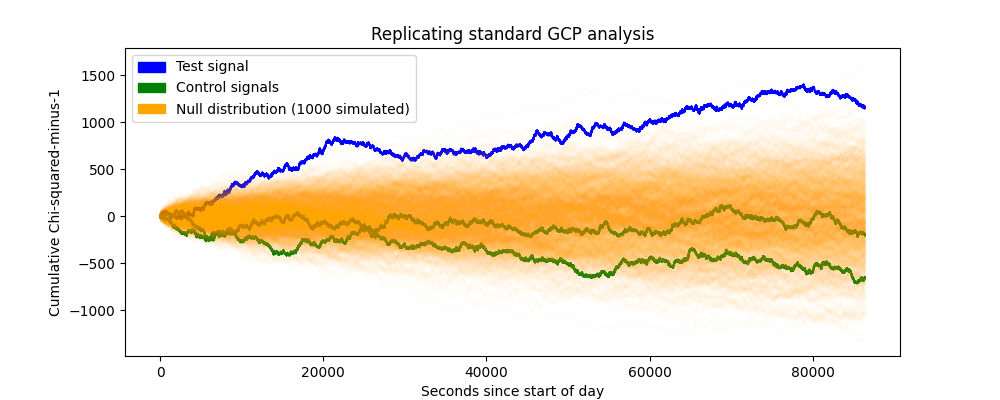

In [3]:
#%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib
matplotlib.use('agg') #needed to prevent mem leak sigh
import matplotlib.patches as mpatches

#replicate the figure at https://global-mind.org/valentines.09.html
fig = plt.figure(figsize=(10,4))
plt.plot(np.arange(len(csm1_test)),np.cumsum(csm1_test), color="blue")
plt.plot(np.arange(len(csm1_control1)),np.cumsum(csm1_control1), color="green")
plt.plot(np.arange(len(csm1_control1)),np.cumsum(csm1_control2), color="green")

#also plot 1000 simulated controls from pseudorandom data
rng = np.random.RandomState(1234)
for i in range(1000):
  sim_csm1 = np.square(rng.normal(size=len(csm1_test)))-1
  plt.plot(np.arange(len(sim_csm1)),np.cumsum(sim_csm1), color="orange", alpha=0.02)
plt.title("Replicating standard GCP analysis")
plt.xlabel("Seconds since start of day")
plt.ylabel("Cumulative Chi-squared-minus-1")
plt.legend(handles=[mpatches.Patch(color='blue', label='Test signal'),
                    mpatches.Patch(color='green', label='Control signals'),
                    mpatches.Patch(color='orange', label='Null distribution (1000 simulated)')],
           loc="upper left")
fig.savefig('csm1plot.png')
plt.close(fig)
plt.clf()

from IPython.display import Image
Image('csm1plot.png')

Now analyze the power spectra

In [4]:
import scipy
#let's check if the power spectrum of the data shows any biases

def get_normalized_power_spectrum(signal):
  ps = np.square(np.abs(scipy.fft.rfft(signal)))
  #normalize to sum to 1
  return ps/np.sum(ps)

nps_test = get_normalized_power_spectrum(csm1_test)
nps_control1 = get_normalized_power_spectrum(csm1_control1)
nps_control2 = get_normalized_power_spectrum(csm1_control2)

#permute the test data sequence 1000 times to get an empirical null
rng = np.random.RandomState(1234)
nps_permutetest_2darr = np.array([get_normalized_power_spectrum(rng.permutation(csm1_test)) for i in range(1000)])

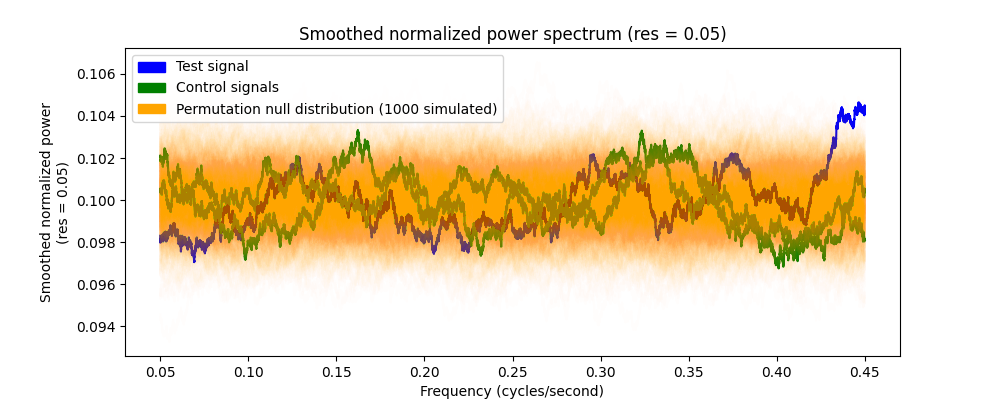

In [5]:
def get_smoothed_arr(arr, windowsize):
  arr_cumsum = np.array([0] + list(np.cumsum(arr)))
  smooth_arr = arr_cumsum[windowsize:] - arr_cumsum[:-windowsize]
  return smooth_arr

FREQSMOOTH = 0.05
#smooth the normalized power spectrum. Smoothing window depends on the step size between frequencies
freqs = np.fft.rfftfreq(len(csm1_test), 1) #get the frequencies
freq_stepsize = freqs[1]
#figure out how many steps fit in freqsmoothwindow, round down
windowsize = int(FREQSMOOTH/freq_stepsize)
#now smooth
smooth_nps_test = get_smoothed_arr(nps_test, windowsize)
smooth_nps_control1 = get_smoothed_arr(nps_control1, windowsize)
smooth_nps_control2 = get_smoothed_arr(nps_control2, windowsize)
smooth_nps_permutetest_2darr = np.array([ get_smoothed_arr(x,windowsize)
                                      for x in nps_permutetest_2darr ])

#plot the smoothed spectra
smooth_xaxis = np.linspace(FREQSMOOTH, max(freqs)-FREQSMOOTH, num=len(smooth_nps_test))

matplotlib.use('agg') #needed to prevent mem leak sigh
fig = plt.figure(figsize=(10,4))
plt.plot(smooth_xaxis, smooth_nps_test, color="blue")
plt.plot(smooth_xaxis, smooth_nps_control1, color="green")
plt.plot(smooth_xaxis, smooth_nps_control2, color="green")
#Also plot the 1000 power spectra from the permuted test data
for smooth_nps_permutetest in smooth_nps_permutetest_2darr:
  plt.plot(smooth_xaxis, smooth_nps_permutetest, color="orange", alpha=0.01)
plt.ylabel("Smoothed normalized power\n(res = "+str(FREQSMOOTH)+")")
plt.xlabel("Frequency (cycles/second)")
plt.title("Smoothed normalized power spectrum (res = "+str(FREQSMOOTH)+")")
plt.legend(handles=[mpatches.Patch(color='blue', label='Test signal'),
                    mpatches.Patch(color='green', label='Control signals'),
                    mpatches.Patch(color='orange', label='Permutation null distribution (1000 simulated)')],
           loc="upper left")
fig.savefig('smooth_nps.png')
plt.close(fig)
plt.clf()
Image("smooth_nps.png")

Test p value: 0.072
Control 1 p value: 0.551
Control 2 p value: 0.537


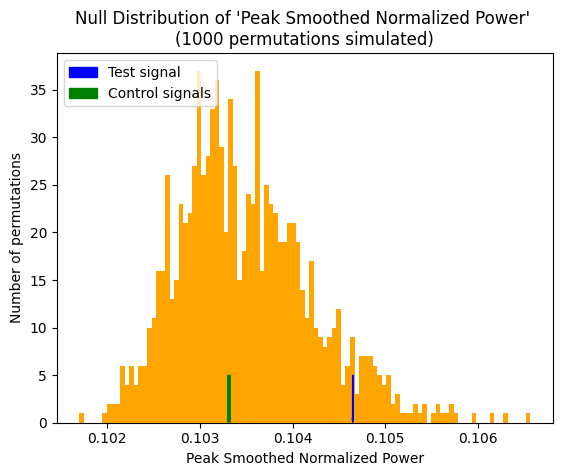

In [6]:
%matplotlib inline
#test if the peak in the smoothed frequency is significant
#msf = max smoothed freq
msf_test = np.max(smooth_nps_test)
msf_control1 = np.max(smooth_nps_control1)
msf_control2 = np.max(smooth_nps_control2)

msf_permutetest_arr = np.max(smooth_nps_permutetest_2darr, axis=1);

pvalue_test = np.sum(msf_permutetest_arr >= msf_test)/len(msf_permutetest_arr)
pvalue_control1 = np.sum(msf_permutetest_arr >= msf_control1)/len(msf_permutetest_arr)
pvalue_control2 = np.sum(msf_permutetest_arr >= msf_control2)/len(msf_permutetest_arr)

print("Test p value:",pvalue_test)
print("Control 1 p value:",pvalue_control1)
print("Control 2 p value:",pvalue_control2)

plt.figure(num=1, clear=True)
plt.hist(msf_permutetest_arr, bins=100, color="orange")
plt.arrow(msf_test, 5, 0, -5, color="blue", head_length=0.5, length_includes_head=True, width=0.000005)
plt.arrow(msf_control1, 5, 0, -5, color="green", head_length=0.5, length_includes_head=True, width=0.000005)
plt.arrow(msf_control2, 5, 0, -5, color="green", head_length=0.5, length_includes_head=True, width=0.000005)
plt.xlabel("Peak Smoothed Normalized Power")
plt.ylabel("Number of permutations")
plt.legend(handles=[mpatches.Patch(color='blue', label='Test signal'),
                    mpatches.Patch(color='green', label='Control signals')],
           loc="upper left")
plt.title("Null Distribution of 'Peak Smoothed Normalized Power' \n(1000 permutations simulated)")

plt.show()

Test p value: 0.01
Control 1 p value: 0.661
Control 2 p value: 0.859


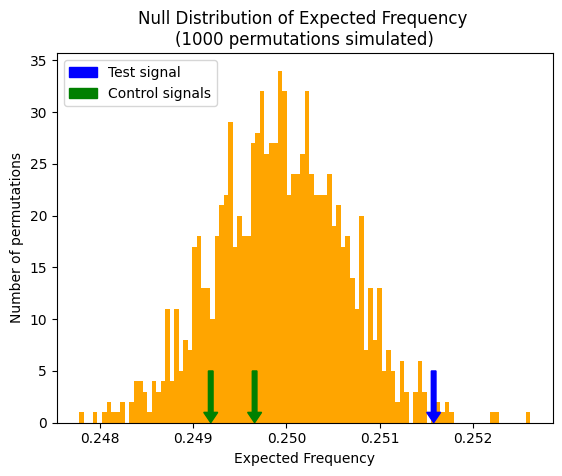

In [7]:
%matplotlib inline
#looks like there is also a bias towards higher frequencies in the test signal.
#We can check this by summing the frequencies weighted by their corresponding
# probabilities from the normalized power spectrum

#ef = expected frequency
ef_permutetest_arr = np.sum(freqs[None,:]*nps_permutetest_2darr, axis=1);

ef_test = np.sum(freqs*nps_test)
ef_control1 = np.sum(freqs*nps_control1)
ef_control2 = np.sum(freqs*nps_control2)

pvalue_test = np.sum(ef_permutetest_arr >= ef_test)/len(ef_permutetest_arr)
pvalue_control1 = np.sum(ef_permutetest_arr >= ef_control1)/len(ef_permutetest_arr)
pvalue_control2 = np.sum(ef_permutetest_arr >= ef_control2)/len(ef_permutetest_arr)

print("Test p value:",pvalue_test)
print("Control 1 p value:",pvalue_control1)
print("Control 2 p value:",pvalue_control2)

plt.figure(num=1, clear=True)
plt.hist(ef_permutetest_arr, bins=100, color="orange")
plt.arrow(ef_test, 5, 0, -5, color="blue", head_length=1, length_includes_head=True, width=0.00005)
plt.arrow(ef_control1, 5, 0, -5, color="green", head_length=1, length_includes_head=True, width=0.00005)
plt.arrow(ef_control2, 5, 0, -5, color="green", head_length=1, length_includes_head=True, width=0.00005)
plt.xlabel("Expected Frequency")
plt.ylabel("Number of permutations")
plt.legend(handles=[mpatches.Patch(color='blue', label='Test signal'),
                    mpatches.Patch(color='green', label='Control signals')],
           loc="upper left")
plt.title("Null Distribution of Expected Frequency \n(1000 permutations simulated)")

plt.show()

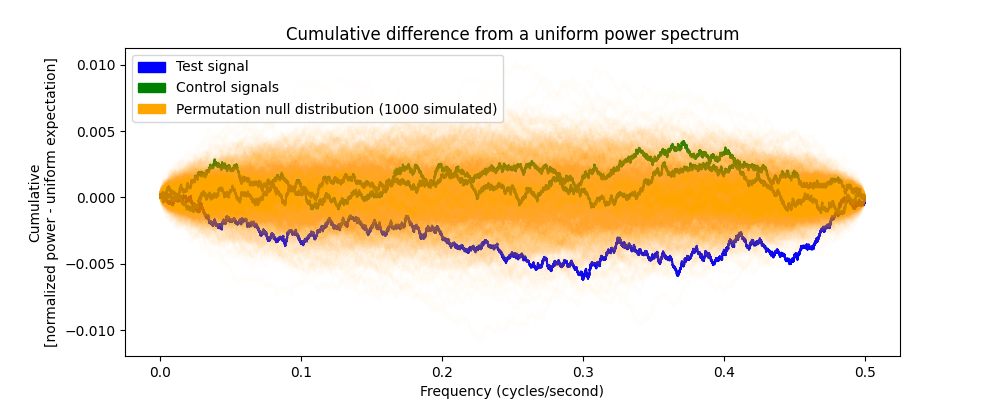

In [8]:
uniform_expectation = 1.0/len(nps_test) #what you expect for each frequency if the power spectrum is perfectly uniform

#plot the cumulative sum of the normalized power spectrum relative to a perfectly uniform power spectrum
matplotlib.use('agg') #needed to prevent mem leak sigh
fig = plt.figure(figsize=(10,4))
plt.plot(freqs, np.cumsum(nps_test - uniform_expectation), color="blue")
plt.plot(freqs, np.cumsum(nps_control1 - uniform_expectation), color="green")
plt.plot(freqs, np.cumsum(nps_control2 - uniform_expectation), color="green")
#Also plot the 1000 power spectra from the permuted test data
for ps_permutetest in nps_permutetest_2darr:
  plt.plot(freqs, np.cumsum(ps_permutetest - uniform_expectation), color="orange", alpha=0.02)
plt.ylabel("Cumulative\n[normalized power - uniform expectation]")
plt.xlabel("Frequency (cycles/second)")
plt.title("Cumulative difference from a uniform power spectrum")
plt.legend(handles=[mpatches.Patch(color='blue', label='Test signal'),
                    mpatches.Patch(color='green', label='Control signals'),
                    mpatches.Patch(color='orange', label='Permutation null distribution (1000 simulated)')],
           loc="upper left")
fig.savefig('cumdev_ups.png')
plt.close(fig)
plt.clf()
Image("cumdev_ups.png")

Test p value: 0.029
Control 1 p value: 0.881
Control 2 p value: 0.312


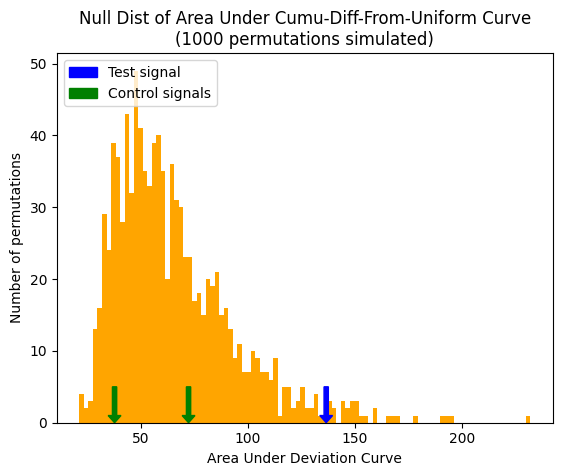

In [9]:
%matplotlib inline
#test if the area under the "deviation from uniform CDF" curve is significant
#audc = area under deviation curve
audc_test = np.sum(np.abs(np.cumsum(nps_test - uniform_expectation)))
audc_control1 = np.sum(np.abs(np.cumsum(nps_control1 - uniform_expectation)))
audc_control2 = np.sum(np.abs(np.cumsum(nps_control2 - uniform_expectation)))

audc_permutetest_arr = np.sum(np.abs(np.cumsum(nps_permutetest_2darr - uniform_expectation, axis=1)), axis=1);

pvalue_test = np.sum(audc_permutetest_arr >= audc_test)/len(audc_permutetest_arr)
pvalue_control1 = np.sum(audc_permutetest_arr >= audc_control1)/len(audc_permutetest_arr)
pvalue_control2 = np.sum(audc_permutetest_arr >= audc_control2)/len(audc_permutetest_arr)

print("Test p value:",pvalue_test)
print("Control 1 p value:",pvalue_control1)
print("Control 2 p value:",pvalue_control2)

plt.figure(num=1, clear=True)
plt.hist(audc_permutetest_arr, bins=100, color="orange")
plt.arrow(audc_test, 5, 0, -5, color="blue", head_length=1, length_includes_head=True, width=2)
plt.arrow(audc_control1, 5, 0, -5, color="green", head_length=1, length_includes_head=True, width=2)
plt.arrow(audc_control2, 5, 0, -5, color="green", head_length=1, length_includes_head=True, width=2)
plt.xlabel("Area Under Deviation Curve")
plt.ylabel("Number of permutations")
plt.legend(handles=[mpatches.Patch(color='blue', label='Test signal'),
                    mpatches.Patch(color='green', label='Control signals')],
           loc="upper left")
plt.title("Null Dist of Area Under Cumu-Diff-From-Uniform Curve\n(1000 permutations simulated)")

plt.show()